In [1]:
from classes import *
from utils import *
import math

from typing import List, Set, Tuple, Any, Dict, DefaultDict, Optional
from collections import defaultdict
import linearize_io_helper as io_helper

%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [39]:
def linearize_io(spec: List[Call]):
    sort_by_var: DefaultDict[int, List[Call]] = defaultdict(list)
    false_cases: List[CallCAS] = []
    true_cases: List[CallCAS] = []
    
    io_helper.populate_call_bins(spec, sort_by_var, true_cases, false_cases)
    
    writes = io_helper.basic_io_checks(sort_by_var)
    if writes is None:
        return False 
    
    if not io_helper.basic_true_cas_checks(true_cases):
        return False
    
    io_helper.topological_true_cas_sort(true_cases)

    true_cas_var_groups: List[List[int]] = []
    for true_cas in true_cases:
        for group in true_cas_var_groups:
            if true_cas.compare == group[-1]:
                group.append(true_cas.swap)
                break
        else:
            true_cas_var_groups.append([true_cas.compare, true_cas.swap])


    true_cas_call_groups: List[List[Call]] = []
    for group in true_cas_var_groups:
        all_group_ops: List[Call] = []
        for var in group:
            all_group_ops.extend(sort_by_var[var])
        all_group_ops = list(dict.fromkeys(all_group_ops))
        true_cas_call_groups.append(all_group_ops)

    # intra-group check
    for group_i in range(len(true_cas_var_groups)):
        intra_group_bins = defaultdict(list)
        io_helper.populate_call_bins(true_cas_call_groups[group_i], intra_group_bins, [], [])
        intra_group_intervals = io_helper.make_intervals(intra_group_bins)
        order = true_cas_var_groups[group_i]
        if io_helper.true_cas_intra_group_check(intra_group_intervals, order) is not True:
            return False
       

    # inter-group check
    for var_group in true_cas_var_groups:
        var = var_group[0]
        for other_var in var_group[1:]:
            sort_by_var[var].extend(sort_by_var[other_var])
            del sort_by_var[other_var]

    intervals: Dict[int, I] = io_helper.make_intervals(sort_by_var)

    if not io_helper.io_check(intervals):
        return False

    blocks = io_helper.make_blocks(intervals)


    false_cas_var_resolver: Dict[CallCAS, Set[int]] = {}
    false_cases.sort(key=lambda x: x.end)
    for false_cas in false_cases:
            available_writes: List[int] = []
            block_i = 0

            while block_i < len(blocks):
                block = blocks[block_i]

                if min((min(c.end for c in sort_by_var[var]) for var in block)) < false_cas.start:
                    available_writes.clear()
                    
                writes_in_block = {var for var in block if writes[var].start < false_cas.end}

                available_writes.extend(writes_in_block)

                if len(writes_in_block) == 0:
                    break

                line = 0
                for var in writes_in_block:
                    interval = intervals[var]
                    if interval.reversed:
                        line = max(line, interval.start)
                    else:
                        line = max(line, interval.end)

                if false_cas.end > line:
                    block_i += 1
                else:
                    break

            # if the false cas is fully contained in a forward interval then the only available write is of that interval
            for var in available_writes.copy():
                interval = intervals[var]
                if interval.reversed:
                    continue
                if I(false_cas.start, false_cas.end).isContainedIn(interval):
                    available_writes = [var]
                    break
            
            if false_cas.compare in available_writes:
                available_writes.remove(false_cas.compare)

            false_cas_var_resolver[false_cas] = set(available_writes)

    # print(blocks)
    # print({f"{k} ({round(k.start, 2)} - {round(k.end,2)})":v for k,v in false_cas_var_resolver.items()})

    visited: Dict[int, I] = {}
    for false_cas in false_cases:
        for var in false_cas_var_resolver[false_cas].copy():
            if var in visited:
                if I(false_cas.start, false_cas.end).isContainedIn(visited[var]):
                    false_cas_var_resolver[false_cas].remove(var)

        if false_cas.compare not in visited:
            if false_cas.compare in writes:
                # if false_cas.end < writes[false_cas.compare].start:
                #     visited[false_cas.compare] = I(false_cas.end, writes[false_cas.compare].start)
                if false_cas.start > writes[false_cas.compare].end:
                    visited[false_cas.compare] = I(false_cas.end, math.inf)

        if len(false_cas_var_resolver[false_cas]) == 0:
            return false_cas.compare
    
    return True


<IPython.core.display.Javascript object>

In [37]:
test = load_test("big_false.pkl")

<IPython.core.display.Javascript object>

In [5]:
# generate_tests(filename="big_false.pkl",
#                success_percentage=0.3,
#                total = 1_500_000,
#                no_threads= 3,
#                no_operations=8,
#                no_variables=4,
#                min_ops=7,
#                min_cas=1,
#                min_read=1)

<IPython.core.display.Javascript object>

In [6]:
def run_test(testsample: List[Tuple[List[Call], bool]]):
    wrong_test_no = []
    for i in tqdm.tqdm(range(len(testsample))):
        testcase, res = copy.deepcopy(testsample[i])
        try:
            sol = linearize_io(testcase)
            s2 = (sol is True)
            if res ^ s2:
                wrong_test_no.append(i)

        except AssertionError as e:
            raise e

    print(f"Tests failed: {len(wrong_test_no)}")
    if len(wrong_test_no) == 0:
        print("All tests passed")
    else:
        print(f"First failed: {str(wrong_test_no[:10]).strip('[]')} ...")
    
    return wrong_test_no

<IPython.core.display.Javascript object>

In [40]:
wrong_test_no = run_test(test)

100%|██████████| 5000/5000 [00:00<00:00, 7293.55it/s]

Tests failed: 0
All tests passed


<IPython.core.display.Javascript object>

In [41]:
c_true = 0
false_false = []
for i in range(len(wrong_test_no)):
    if test[wrong_test_no[i]][1] is True:
        c_true += 1
        false_false.append(wrong_test_no[i])

print(c_true)
print(false_false)

0
[]


<IPython.core.display.Javascript object>

Testcase 2596 is False
[[0, 4], [3]]
{'!1 (1.68 - 5.29)': {0}, '!4 (13.71 - 23.76)': {0}, '!2 (28.61 - 30.51)': {0, 4}}
True


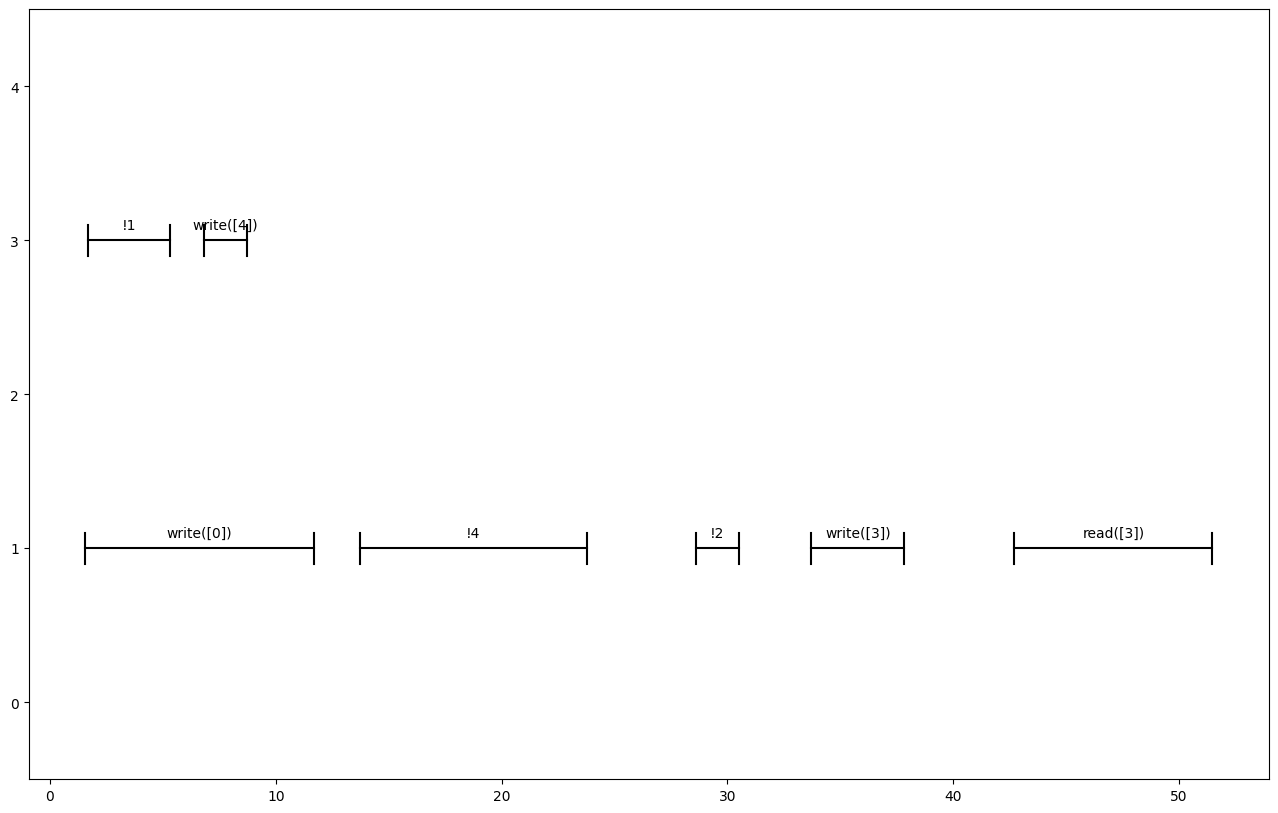

<IPython.core.display.Javascript object>

In [35]:
i = 2596
testcase, res = copy.deepcopy(test[i])
print(f"Testcase {i} is {res}")
print(linearize_io(testcase))
# sol = linearize_generic(testcase, StateIO())
# visualize_history(testcase)
visualize_history(testcase)

# !3: [1,3]

# Idea 1: Splitting blocks
# Idea 2: False cases want different different values at the same time

Testcase 115509 is True


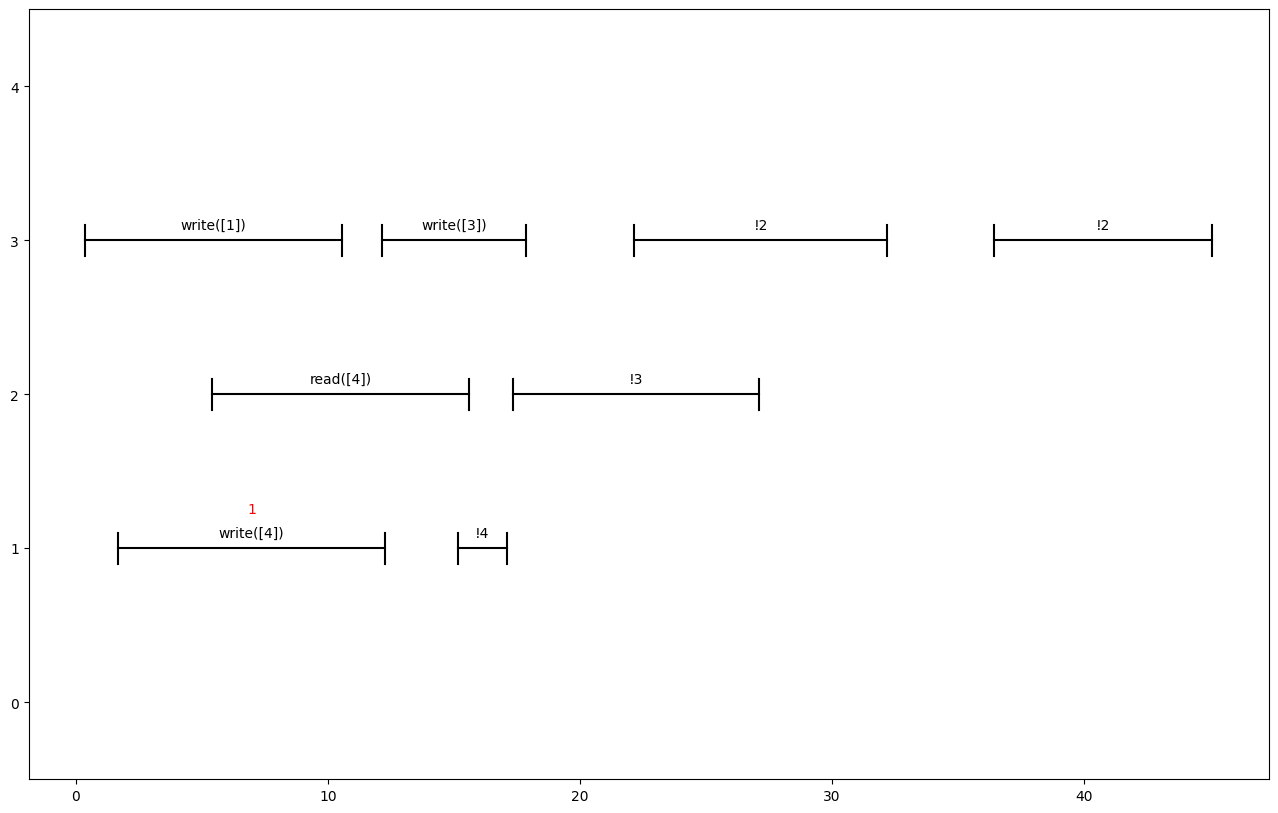

<IPython.core.display.Javascript object>

In [ ]:
testcase, res = copy.deepcopy(test[i])
print(f"Testcase {i} is {res}")
visualize_history(testcase)

In [ ]:
for wrong_test in wrong_test_no[:10]:
    testcase, res = copy.deepcopy(test[wrong_test])
    print(f"Testcase {wrong_test} is {res}")
    print(linearize_io(testcase))
    visualize_history(testcase)

# Problems:
# 1. Block chaining. [115509, 503578, 740279, 952512]
# 2. Non-independent CASes. [757, 1644, 2091, 2596, 2767, 4460, 5759, 7172, 7964, 10536...]

# 757 - There is a single value in the register, if 